In [122]:
# Imports
import os
import numpy as np
import pandas as pd
from astropy.table import Table

In [123]:
data_folder = "data-2019-09-23-nickel-joey-anne"

## Load the photometry measurements from file

In [124]:
ngc6819_v_phot = Table.read(os.path.join(data_folder, 'photometry/ngc6819_v_matched_cleaned_iter_3.dat'), format='ascii')
ngc6819_b_phot = Table.read(os.path.join(data_folder, 'photometry/ngc6819_b_matched_cleaned_iter_3.dat'), format='ascii')

landolt_v_phot = Table.read(os.path.join(data_folder, 'photometry/landolt_v.dat'), format='ascii')
landolt_b_phot = Table.read(os.path.join(data_folder, 'photometry/landolt_b.dat'), format='ascii')

## Make sure the indices match 

In [125]:
landolt_v_phot

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64
297.7192446421318,297.7538899395244,89.40653474429064,89.13105871332692,64108.95917251523,53670.10024687822,1,1,2873.534095611987,0.15314793207972988,0.15313078784776077,1
221.36880305315282,221.48024597109293,254.58604691605123,254.63230555817503,168558.19445178768,140127.7957145692,2,2,7427.159668382596,0.15168088353994316,0.15163316364663995,1
810.0468906218109,809.9313193787901,399.78868477550446,399.7681404564521,32635.432877755647,27605.590910825595,3,3,1357.179063250943,0.1406234370015771,0.140605181482703,1


In [126]:
landolt_b_phot

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
297.15286084474883,88.68384323005239,20259.982321347634,1,1,296.10451471833517,87.36485270035352,17820.483709541655,957.5548232545625,0.15402184096057475,0.1555341844175047
220.80241789201403,253.86335507588052,42603.91172707826,2,2,219.8997511545067,252.85163853521215,36472.34812429178,1987.1962635907385,0.1564295111490652,0.1564992242738294
809.480504532303,399.06599799846157,31476.314396463193,3,3,807.8330447459327,398.2732750815672,27939.865057612853,1608.9220607210098,0.16539135057937268,0.16490159943016522


## True Landolt #125 magnitudes
From: http://www.wiyn.org/Observe/Landolt/charts/c125.html

In [127]:
landolt_1965_v_mag = 11.419
landolt_1969_v_mag = 10.382
landolt_1925_v_mag = 12.388
landolt_v_mags = np.array([landolt_1965_v_mag, landolt_1969_v_mag, landolt_1925_v_mag])

landolt_1965_b_mag = landolt_1965_v_mag + 1.710
landolt_1969_b_mag = landolt_1969_v_mag + 1.959
landolt_1925_b_mag = landolt_1925_v_mag + 0.395
landolt_b_mags = np.array([landolt_1965_b_mag, landolt_1969_b_mag, landolt_1925_b_mag])

## Some constants

### Landolt image exposure times
From: https://docs.google.com/spreadsheets/d/1tiIF8VI7EcfBdhocXvWXtCffNllyym3ZdUw7BWaMaX0/edit?ts=5d890f31#gid=0

In [128]:
EXP_TIME_LANDOLT_V = 5.0   # seconds
EXP_TIME_LANDOLT_B = 10.0  # seconds
EXP_TIME_NGC6819   = 120.0 # seconds

### Distance to NGC6819
From: https://arxiv.org/abs/1603.00474

In [129]:
DISTANCE = 2.309e3 # pc

## Measure the zero points in both V and B filters

In [130]:
def zero_point(mag, DN, exp_time):
    return mag + 2.5 * np.log10(DN / exp_time)

def mag(DN, ZP, exp_time):
    return -2.5 * np.log10(DN / exp_time) + ZP

def abs_mag(m, d):
    '''
    m: relative magnitude
    d: distance (in pc)
    '''
    return m - 2.5 * np.log10((d/10)**2)

In [131]:
landolt_v_flux = np.array(landolt_v_phot['flux_fit'])
landolt_b_flux = np.array(landolt_b_phot['flux_fit'])

In [132]:
ZP_V = np.mean(zero_point(landolt_v_mags, landolt_v_flux, EXP_TIME_LANDOLT_V))
ZP_B = np.mean(zero_point(landolt_b_mags, landolt_b_flux, EXP_TIME_LANDOLT_B))

print('Zero Point Magnitude in V = {:.4f}'.format(ZP_V))
print('Zero Point Magnitude in B = {:.4f}'.format(ZP_B))

Zero Point Magnitude in V = 21.5800
Zero Point Magnitude in B = 21.3003


## Measure the B and V magnitudes in NGC6819

In [133]:
ngc6819_v_mags = mag(np.array(ngc6819_v_phot['flux_fit']), ZP_V, EXP_TIME_NGC6819)
ngc6819_b_mags = mag(np.array(ngc6819_b_phot['flux_fit']), ZP_B, EXP_TIME_NGC6819)

ngc6819_b_minus_v = ngc6819_b_mags - ngc6819_v_mags

## Measure the absolute magnitude in V

In [134]:
ngc6819_abs_v_mags = abs_mag(ngc6819_v_mags, DISTANCE)

## Save the calibrated magnitude and color measurements

In [135]:
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_v_mags_iter_3.npy'), ngc6819_v_mags)
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_b_mags_iter_3.npy'), ngc6819_b_mags)
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_b_minus_v_iter_3.npy'), ngc6819_b_minus_v)
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_abs_v_mags_iter_3.npy'), ngc6819_abs_v_mags)

## Inspect the cleaned data by eye

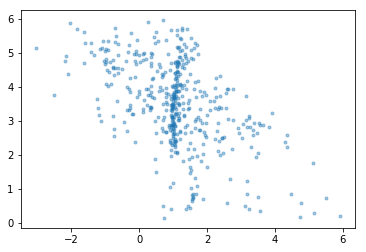

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ngc6819_b_minus_v, ngc6819_abs_v_mags, '.', alpha=0.4)
plt.show()

In [137]:
# Remove any obvious outliers
bad_ind = np.argmin(ngc6819_b_minus_v)
ngc6819_v_mags = np.delete(ngc6819_v_mags, bad_ind)
ngc6819_b_mags = np.delete(ngc6819_b_mags, bad_ind)
ngc6819_b_minus_v = np.delete(ngc6819_b_minus_v, bad_ind)
ngc6819_abs_v_mags = np.delete(ngc6819_abs_v_mags, bad_ind)

In [90]:
# Overwrite the old files
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_v_mags_iter_2.npy'), ngc6819_v_mags)
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_b_mags_iter_2.npy'), ngc6819_b_mags)
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_b_minus_v_iter_2.npy'), ngc6819_b_minus_v)
np.save(os.path.join(data_folder, 'color_and_mag_results/ngc6819_abs_v_mags_iter_2.npy'), ngc6819_abs_v_mags)

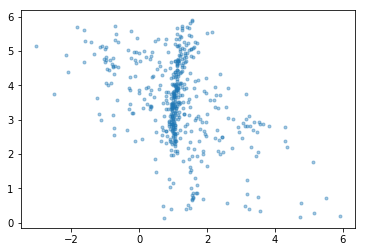

In [91]:
# Double check
plt.plot(ngc6819_b_minus_v, ngc6819_abs_v_mags, '.', alpha=0.4)
plt.show()